<a href="https://colab.research.google.com/github/valuntiny/kaggle_intermediate_ML/blob/master/kaggle_intermediate_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Guojing Wu** *| 2019-07-31*

<a href = "https://www.kaggle.com/alexisbcook/pipelines"> Kaggle: Intermediate Machine Learning </a>

# Objectives

* missing value

* pipelines

* CV

* XGBoost

* leakage

# pipeline

Two main function:

* ColumnTransformer

* Pipeline

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('drive/My Drive/self_ML/Intermediate ML/train.csv', index_col='Id')
X_test_full = pd.read_csv('drive/My Drive/self_ML/Intermediate ML/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [0]:
numerical_transformer = SimpleImputer(strategy='median')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

model = RandomForestRegressor(n_estimators=100, random_state=0)

my_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor), 
    ('model', model)
])

In [4]:
my_pipeline.fit(X_train, y_train)
mean_absolute_error(my_pipeline.predict(X_valid), y_valid)

17553.371061643833

# Cross Validation

using pipeline

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
train_data = pd.read_csv('drive/My Drive/self_ML/Intermediate ML/train.csv', index_col='Id')
test_data = pd.read_csv('drive/My Drive/self_ML/Intermediate ML/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = train_data.SalePrice
train_data.drop(['SalePrice'], axis=1, inplace=True)

# Select numeric columns only
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
X = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

# piping
my_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

In [12]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("Average MAE score:", scores.mean())

Average MAE score: 18054.97936073059


Combine everything into a function

In [13]:
def get_score(n_estimators):
    my_pipeline = Pipeline(steps=[
        ('preprocessor', SimpleImputer()),
        ('model', RandomForestRegressor(n_estimators=n_estimators, random_state=0))
    ])
    scores = -1 * cross_val_score(my_pipeline, X, y, 
                                  cv=5, 
                                  scoring='neg_mean_absolute_error')
    
    return scores.mean()

get_score(100)

18054.97936073059

Search the best hyperparameter during a loop

In [14]:
res = {}
for i in range(1, 9):
    res[i*50] = get_score(i*50)
res

{50: 18276.410356164386,
 100: 18054.97936073059,
 150: 17964.667534246575,
 200: 17937.141941780825,
 250: 17935.837222961512,
 300: 17923.89181974342,
 350: 17918.986291026,
 400: 17929.15917131441}

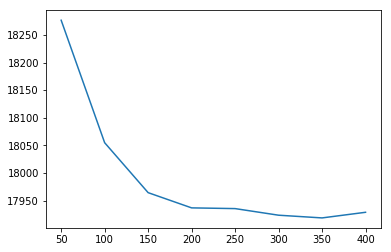

In [15]:
import matplotlib.pyplot as plt

plt.plot(res.keys(), res.values())
plt.show()

In python sklearn lab, there is also a grid search function called `GridSearchCV()` that can make the hyperparameter searching process more efficient.